# Цели и задачи проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [1]:
# Загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Загружаем данные
stud = pd.read_csv('stud_math.xls')

In [2]:
# Посмотрим, из чего состоит датасет.
display(stud.head(10))
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Данные имеют 13 числовых признаков и 17 номинативных.

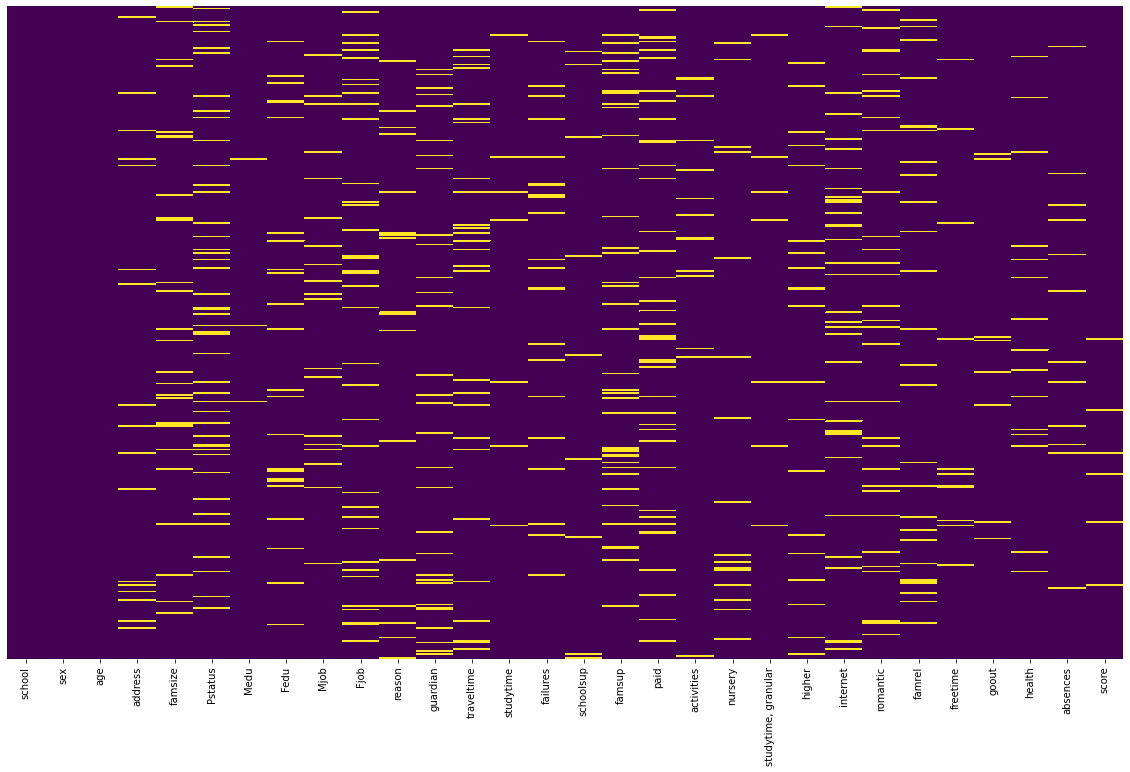

In [3]:
# Визуализируем пропуски с помощью библиотеки Seaborn
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(stud.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Первые три признаки без пропусков, остальные с пропусками.

In [177]:
# Напишем функции, которые можно применять к столбцам определённого типа

def eda_nom(column, bins=None):
    """
    Предобработка номинативных признаков
    """
    column = stud[column]

    # Вывдем статистики
    display(column.describe())

    fig, axs = plt.subplots(nrows=2)

    # Построим гистограмму распределения признака
    sns.countplot(x=column.name, data=stud, ax=axs[0]);

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    # Выведем "ящики с усами"
    sns.boxplot(x=column.name, y='score', data=stud, ax=axs[1])


def eda_num(column, bins=8):
    """
    Предобработка числовых признаков
    """
    column = stud[column]

    # Выведем количество уникальных значений
    print('Количество уникальных значений: {}'.format(column.nunique()))

    # Вывдем статистики
    display(column.describe())

    # Построим гистограмму распределения признака
    if bins == None:
        bins = column.nunique()
    fig, ax = plt.subplots()
    ax.hist(column, bins=bins)
    ax.set_title('Распределение признака {}'.format(column.name, 2))

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    # Визуализируем наличие выбросов
    fig, ax = plt.subplots()
    sns.boxplot(column, orient='v')
    ax.set_title('Визуализация признака {}'.format(column.name, 2))

    # Выведем выбросы
    print('Выбросы:')
    display(outliers_iqr(column))


def outliers_iqr(data):
    """
    Функция нахождения выбросов
    """
    # находим квартили
    quartile_1, quartile_3 = np.percentile(data[~data.isna()], [25, 75])
    # находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    # нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    # верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)

    return [lower_bound, upper_bound]


def replace_by_median(column):
    stud[column] = stud[column].fillna(
        stud.describe(include=['object'])[column].top)


def replace_by_new(column, name):
    stud[column] = stud[column].fillna(name)


def nominative_analisys(stud, col):
    permutations_all = list(combinations(
        stud.loc[:, col].dropna().unique(), 2))
    for perm in permutations_all:
        if ttest_ind(stud.loc[stud.loc[:, col] == perm[0], 'score'].dropna(),
                     stud.loc[stud.loc[:, col] == perm[1], 'score'].dropna()).pvalue \
            <= 0.05/len(permutations_all): #Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col)
            break

In [5]:
column = stud['school']
column.name

'school'

# School
Номинативный признак

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

GP    88.35
MS    11.65
Name: school, dtype: float64

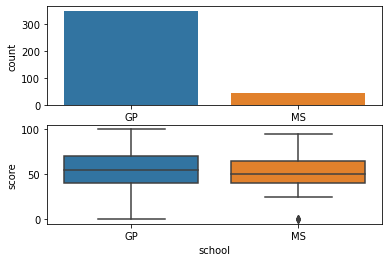

In [6]:
eda_nom('school')

Пропусков нет, два уникальных значения, 88% - GP, остальное - MS.

# sex
Номинативный (бинарный) признак 

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

F    52.66
M    47.34
Name: sex, dtype: float64

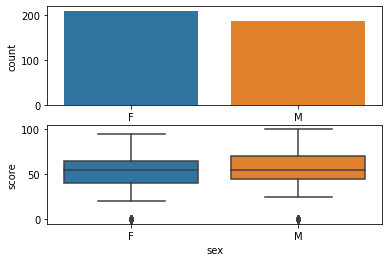

In [7]:
eda_nom('sex')

Пропуски отсутствуют, два уникальных значения.

## age
Числовое значение

Количество уникальных значений: 8


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    26.33
17    24.81
18    20.76
15    20.76
19     6.08
20     0.76
22     0.25
21     0.25
Name: age, dtype: float64

Выбросы:


247    22
Name: age, dtype: int64

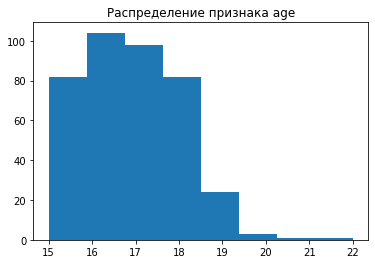

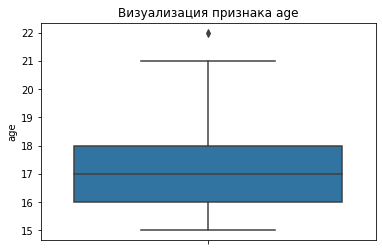

In [8]:
eda_num('age', bins=None)

In [9]:
# Удалим выборос
stud = stud.drop(labels=outliers_iqr(stud.age).index)

Количество уникальных значений: 7


count    394.000000
mean      16.682741
std        1.249267
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

16    26.40
17    24.87
18    20.81
15    20.81
19     6.09
20     0.76
21     0.25
Name: age, dtype: float64

Выбросы:


Series([], Name: age, dtype: int64)

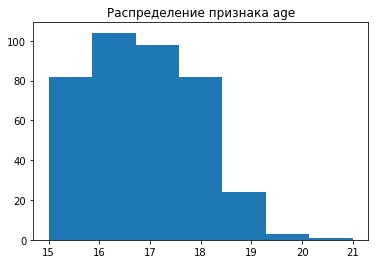

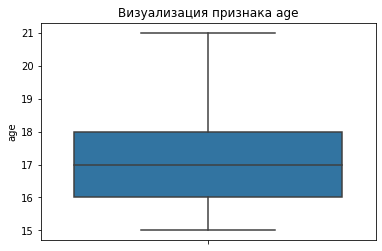

In [10]:
# Проверим, удалился ли выброс
eda_num('age', bins=None)

Числовой признак, имелся один выброс, который мы удалили.

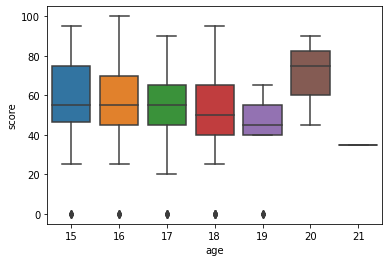

In [11]:
sns.boxplot(y = 'score', x = 'age', data=stud);

## address 
тип адреса ученика ('U' - городской, 'R' - за городом)

count     377
unique      2
top         U
freq      294
Name: address, dtype: object

U      74.62
R      21.07
NaN     4.31
Name: address, dtype: float64

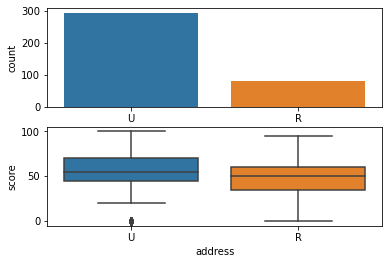

In [12]:
eda_nom('address')

Посмотрим среднее время, которое ученики затрачивают, чтобы добираться до школы, из разных локаций:

In [13]:
stud.groupby(['address', 'school']).traveltime.mean()

address  school
R        GP        1.672727
         MS        2.190476
U        GP        1.320463
         MS        1.529412
Name: traveltime, dtype: float64

Признак категориальный. Как мы видим из нашего распределения, большая часть учеников живут в городе. Вполне логично, что из города до школ добираться быстрее, что и подтвердил анализ среднего значения времени в дороге. Поэтому заменим пропуски на R, если traveltime > 1, а если traveltime = 1, то на U. Если данные в столбце traveltime отсутсвуют - заменим пропуск на U, как на самое часто встречающееся значение.

count     394
unique      2
top         U
freq      305
Name: address, dtype: object

U    77.41
R    22.59
Name: address, dtype: float64

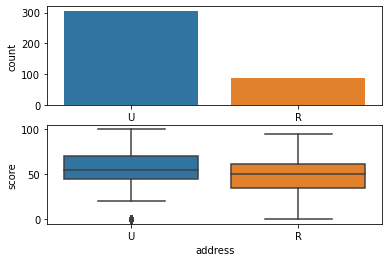

In [14]:
stud['address'] = stud.apply(lambda x: ('R' if x.traveltime > 1 else 'U')\
                             if pd.isna(x.address) else x.address , axis=1)
eda_nom('address')

## famsize
размер семьи('LE3' <= 3, 'GT3' >3)

count     367
unique      2
top       GT3
freq      260
Name: famsize, dtype: object

GT3    65.99
LE3    27.16
NaN     6.85
Name: famsize, dtype: float64

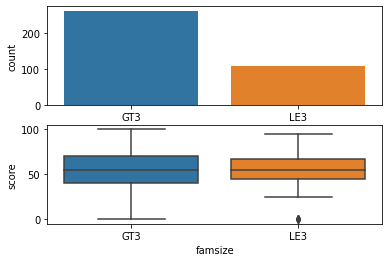

In [15]:
eda_nom('famsize')

Имеется 7% пропусков, заменим их самым часто встречающимся значением.

count     394
unique      2
top       GT3
freq      287
Name: famsize, dtype: object

GT3    72.84
LE3    27.16
Name: famsize, dtype: float64

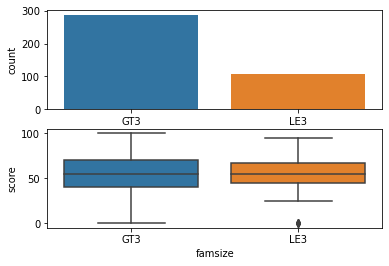

In [16]:
replace_by_median('famsize')
eda_nom('famsize')

## Pstatus
статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

count     349
unique      2
top         T
freq      313
Name: Pstatus, dtype: object

T      79.44
NaN    11.42
A       9.14
Name: Pstatus, dtype: float64

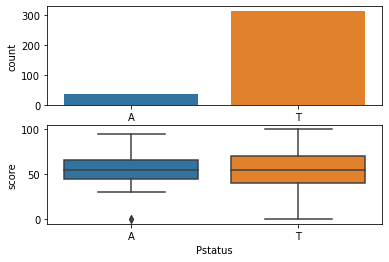

In [17]:
eda_nom('Pstatus')

9% составляют пропуски, создадим новый признак - отсутствующие данные - N.

count     394
unique      3
top         T
freq      313
Name: Pstatus, dtype: object

T    79.44
N    11.42
A     9.14
Name: Pstatus, dtype: float64

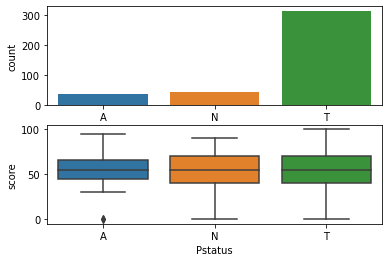

In [18]:
replace_by_new('Pstatus', 'N')
eda_nom('Pstatus')

## Medu
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). Исходя из смысла - это номинативный признак.

In [19]:
# Проверим корреляцию между образованием матери и отца
stud[['Medu', 'Fedu']].dropna().loc[(stud[['Medu', 'Fedu']].dropna().Medu <= 4)
                                    & (stud[['Medu', 'Fedu']].dropna().Fedu <= 4)].corr()

,Medu,Fedu
Medu,1.000000,0.632611
Fedu,0.632611,1.000000


Видим, что корреляция достаточно высокая. Пропуски и ошибки в образовании отца или матери можно заменять образованием матери и отца соответственно.

count    391.000000
mean       2.749361
std        1.099461
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.25
2.0    25.89
3.0    24.37
1.0    14.97
0.0     0.76
NaN     0.76
Name: Medu, dtype: float64

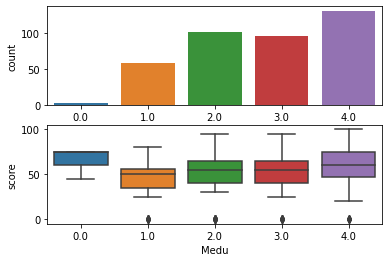

In [20]:
eda_nom('Medu')

0.8% составляют пропуски, заменим из на образование отца.

count    394.000000
mean       2.743655
std        1.099513
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.25
2.0    26.14
3.0    24.62
1.0    15.23
0.0     0.76
Name: Medu, dtype: float64

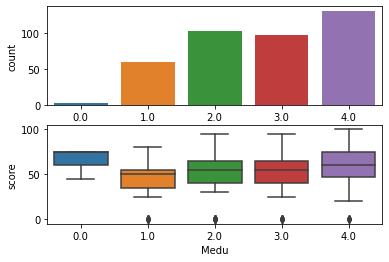

In [21]:
stud.Medu = stud.Medu.fillna(stud.Fedu)
eda_nom('Medu')

## Fedu
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

count    370.000000
mean       2.618919
std        2.230163
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

2.0     26.90
3.0     24.37
4.0     22.34
1.0     19.54
NaN      6.09
0.0      0.51
40.0     0.25
Name: Fedu, dtype: float64

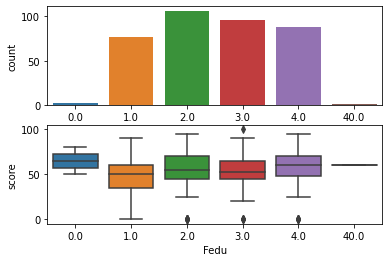

In [22]:
eda_nom('Fedu')

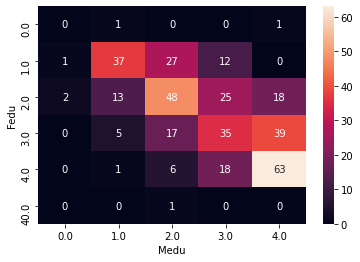

In [23]:
sns.heatmap(pd.crosstab(stud.Fedu, stud.Medu), annot=True);

Имеется ошибка - значение 40, заменим её и пропуски на образование матери.

In [24]:
stud.Fedu = stud.Fedu.apply(lambda x: None if x>4 else x)
stud.Fedu = stud.Fedu.fillna(stud.Medu)

count    394.000000
mean       2.545685
std        1.088545
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

2.0    28.17
3.0    26.14
4.0    24.87
1.0    20.30
0.0     0.51
Name: Fedu, dtype: float64

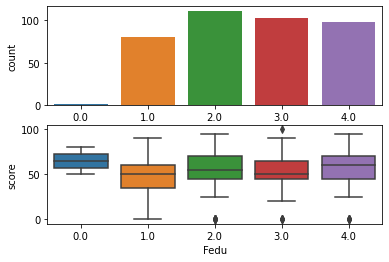

In [25]:
# Проверим результаты
eda_nom('Fedu')

## Mjob
работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       375
unique        5
top       other
freq        133
Name: Mjob, dtype: object

other       33.76
services    24.62
at_home     14.72
teacher     13.96
health       8.12
NaN          4.82
Name: Mjob, dtype: float64

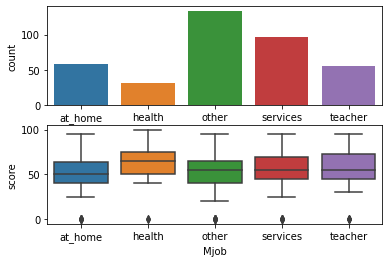

In [26]:
eda_nom('Mjob')

Заполним пропуски значением "other"

In [27]:
stud.Mjob = stud.Mjob.fillna('other')

count       394
unique        5
top       other
freq        152
Name: Mjob, dtype: object

other       38.58
services    24.62
at_home     14.72
teacher     13.96
health       8.12
Name: Mjob, dtype: float64

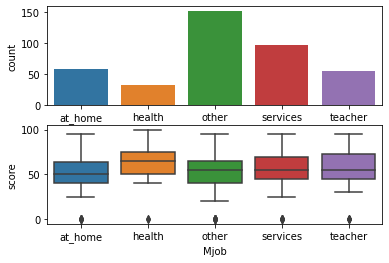

In [28]:
eda_nom('Mjob')

# Fjob - работа отца

 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       358
unique        5
top       other
freq        197
Name: Fjob, dtype: object

other       50.00
services    25.63
NaN          9.14
teacher      7.36
at_home      4.06
health       3.81
Name: Fjob, dtype: float64

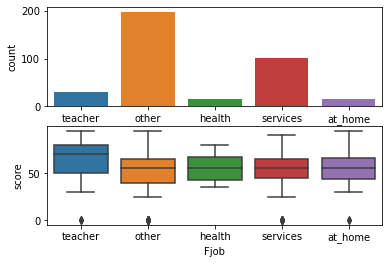

In [29]:
eda_nom('Fjob')

Заполним пропуски значением "other"

In [30]:
stud.Fjob = stud.Fjob.fillna('other')

# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

count        394
unique         4
top       course
freq         154
Name: reason, dtype: object

course        39.09
home          26.40
reputation    26.14
other          8.38
Name: reason, dtype: float64

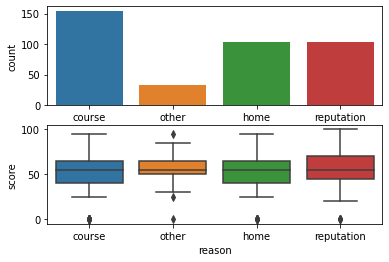

In [36]:
eda_nom('reason')

In [37]:
# сделаем замену пустых значений на самое часто встречающееся значение - course
stud['reason'] = stud['reason'].fillna(
    stud.describe(include=['object']).reason.top)

count        394
unique         4
top       course
freq         154
Name: reason, dtype: object

course        39.09
home          26.40
reputation    26.14
other          8.38
Name: reason, dtype: float64

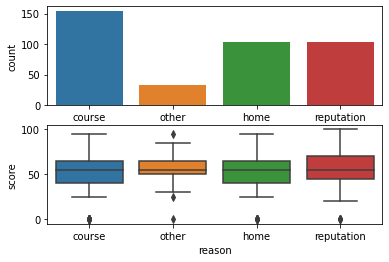

In [38]:
eda_nom('reason')

# 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

count        363
unique         3
top       mother
freq         249
Name: guardian, dtype: object

mother    63.20
father    21.83
NaN        7.87
other      7.11
Name: guardian, dtype: float64

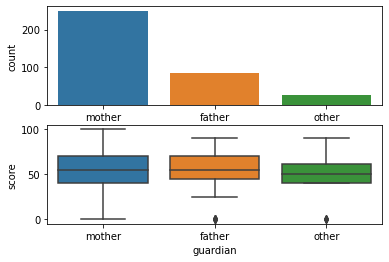

In [39]:
eda_nom('guardian')

Заполним пропуски наиболее часто встречающимся значением

count        394
unique         3
top       mother
freq         280
Name: guardian, dtype: object

mother    71.07
father    21.83
other      7.11
Name: guardian, dtype: float64

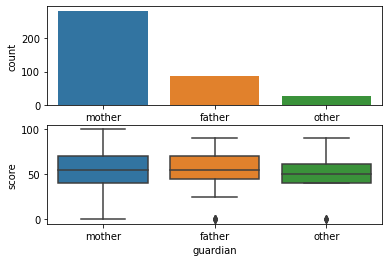

In [40]:
stud.guardian = stud.guardian.fillna(
    stud.describe(include=['object']).guardian.top)
eda_nom('guardian')

# 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Ординальный признак

count    366.000000
mean       1.439891
std        0.694751
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

1.0    61.17
2.0    24.37
NaN     7.11
3.0     5.58
4.0     1.78
Name: traveltime, dtype: float64

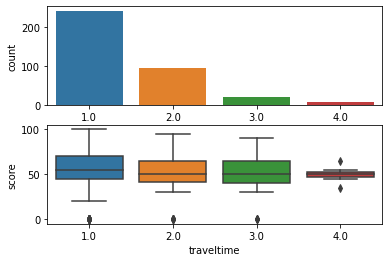

In [41]:
eda_nom('traveltime')

Посмотрим среднее время ученика до школы, чтобы заполнить пропуски

In [46]:
stud.groupby(['address', 'school']).traveltime.mean()

address  school
R        GP        1.684211
         MS        2.200000
U        GP        1.310861
         MS        1.529412
Name: traveltime, dtype: float64

Заменим пропуски следующим образом: присвоим 2, если ученик живёт в пригороде, и 1, если ученик живёт в городе 

count    394.000000
mean       1.426396
std        0.681201
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

1.0    66.50
2.0    26.14
3.0     5.58
4.0     1.78
Name: traveltime, dtype: float64

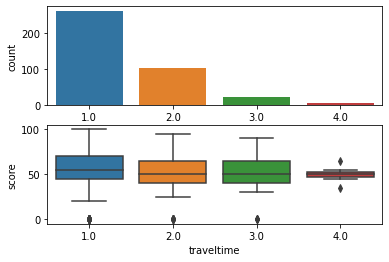

In [56]:
stud.traveltime = stud.apply(lambda x: (2 if x.address == 'R' else 1)
                             if pd.isna(x.traveltime) else x.traveltime, axis=1)
eda_nom('traveltime')

# studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

count    387.000000
mean       2.041344
std        0.841505
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

2.0    49.24
1.0    25.89
3.0    16.24
4.0     6.85
NaN     1.78
Name: studytime, dtype: float64

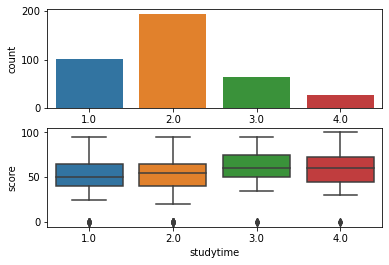

In [57]:
eda_nom('studytime')

Заполним пропуски самым частым значением

count    394.000000
mean       2.040609
std        0.833995
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

2.0    51.02
1.0    25.89
3.0    16.24
4.0     6.85
Name: studytime, dtype: float64

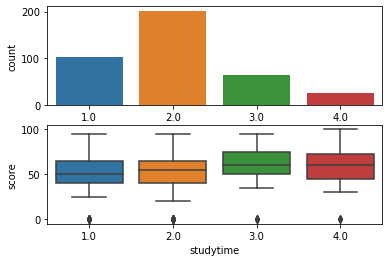

In [66]:
stud.studytime = stud.studytime.fillna(
    stud.describe().studytime['50%'])
eda_nom('studytime')

# 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

count    372.000000
mean       0.330645
std        0.731152
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

0.0    74.37
1.0    12.44
NaN     5.58
2.0     4.06
3.0     3.55
Name: failures, dtype: float64

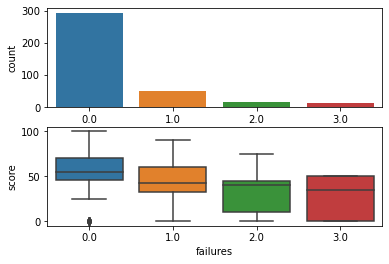

In [67]:
eda_nom('failures')

Заполним пропуски самым частым значением.

count    394.000000
mean       0.312183
std        0.714448
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

0.0    79.95
1.0    12.44
2.0     4.06
3.0     3.55
Name: failures, dtype: float64

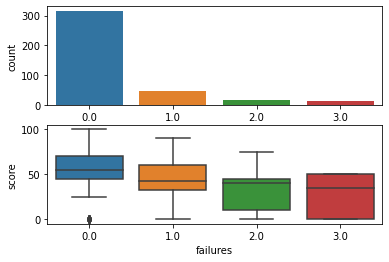

In [68]:
stud.failures = stud.failures.fillna(
    stud.describe().failures['50%'])
eda_nom('failures')

# 16 schoolsup — дополнительная образовательная поддержка (yes или no)

count     385
unique      2
top        no
freq      334
Name: schoolsup, dtype: object

no     84.77
yes    12.94
NaN     2.28
Name: schoolsup, dtype: float64

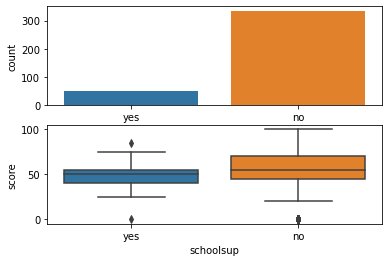

In [69]:
eda_nom('schoolsup')

Заполним пропуски самым частым значением.

count     394
unique      2
top        no
freq      343
Name: schoolsup, dtype: object

no     87.06
yes    12.94
Name: schoolsup, dtype: float64

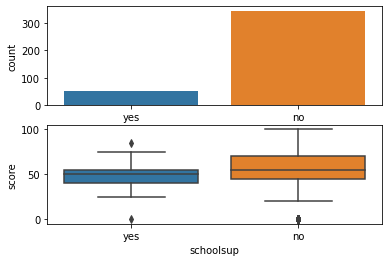

In [70]:
stud['schoolsup'] = stud['schoolsup'].fillna(
    stud.describe(include=['object']).schoolsup.top)
eda_nom('schoolsup')

# 17 famsup — семейная образовательная поддержка (yes или no)

count     355
unique      2
top       yes
freq      219
Name: famsup, dtype: object

yes    55.58
no     34.52
NaN     9.90
Name: famsup, dtype: float64

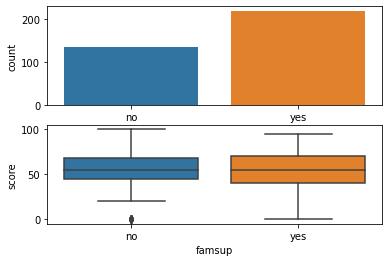

In [71]:
eda_nom('famsup')

Посмотрим, как зависит семейная образовательная поддержка и образование родителей.

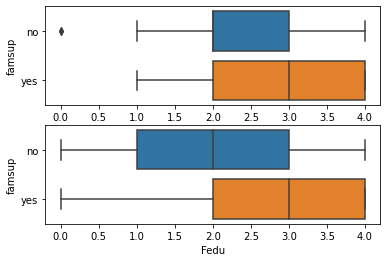

In [109]:
fig, axs = plt.subplots(2,1)
sns.boxplot(x='Medu', y='famsup', data=stud, ax=axs[0])
sns.boxplot(x='Fedu', y='famsup', data=stud, ax=axs[1]);

Заполним пропуски следующим образом: семейная образовательная поддержка есть, если образование отца больше или равно 3.

count     394
unique      2
top       yes
freq      235
Name: famsup, dtype: object

yes    59.64
no     40.36
Name: famsup, dtype: float64

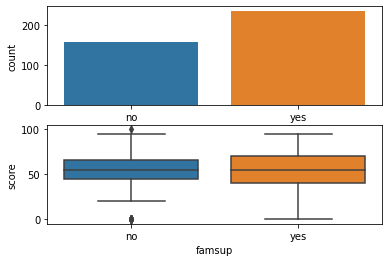

In [111]:
stud.famsup = stud.apply(lambda x: ('yes' if x.Fedu >= 3 else 'no')
                             if pd.isna(x.famsup) else x.famsup, axis=1)
eda_nom('famsup')

# 18 paid — дополнительные платные занятия по математике (yes или no)

count     354
unique      2
top        no
freq      199
Name: paid, dtype: object

no     50.51
yes    39.34
NaN    10.15
Name: paid, dtype: float64

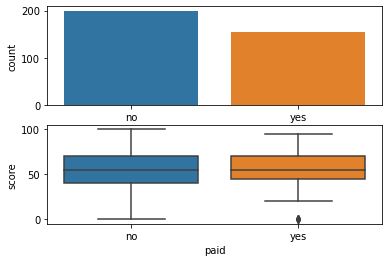

In [112]:
eda_nom('paid')

Заполним пропуски значением 'other'.

count     394
unique      3
top        no
freq      199
Name: paid, dtype: object

no       50.51
yes      39.34
other    10.15
Name: paid, dtype: float64

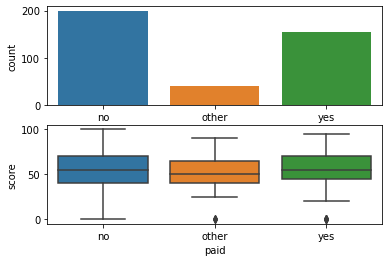

In [114]:
stud.paid = stud.paid.fillna('other')
eda_nom('paid')

# 19 activities — дополнительные внеучебные занятия (yes или no)

count     380
unique      2
top       yes
freq      195
Name: activities, dtype: object

yes    49.49
no     46.95
NaN     3.55
Name: activities, dtype: float64

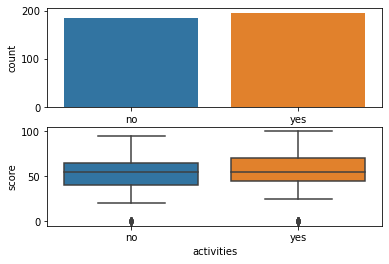

In [115]:
eda_nom('activities')

Заполним пропуски случайным образом.

count     394
unique      2
top       yes
freq      209
Name: activities, dtype: object

yes    53.05
no     46.95
Name: activities, dtype: float64

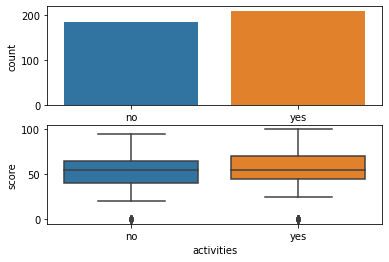

In [116]:
import random
stud.activities = stud.activities.fillna(random.choice(['yes', 'no']))
eda_nom('activities')

# 20 nursery — посещал детский сад (yes или no)

count     378
unique      2
top       yes
freq      300
Name: nursery, dtype: object

yes    76.14
no     19.80
NaN     4.06
Name: nursery, dtype: float64

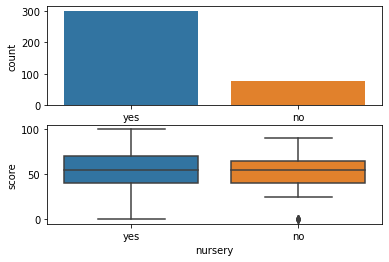

In [117]:
eda_nom('nursery')

Заполним пропуски значением 'yes'.

count     394
unique      2
top       yes
freq      316
Name: nursery, dtype: object

yes    80.2
no     19.8
Name: nursery, dtype: float64

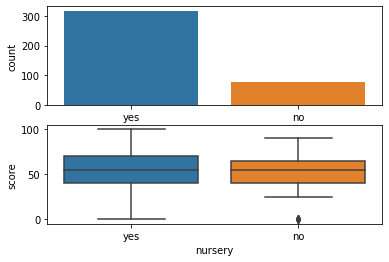

In [119]:
stud.nursery = stud.nursery.fillna('yes')
eda_nom('nursery')

# 21 higher — хочет получить высшее образование (yes или no)

count     374
unique      2
top       yes
freq      356
Name: higher, dtype: object

yes    90.36
NaN     5.08
no      4.57
Name: higher, dtype: float64

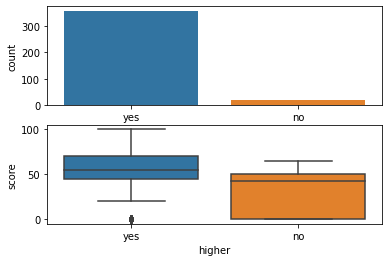

In [120]:
eda_nom('higher')

Заполним пропуски значением 'yes'.

count     394
unique      2
top       yes
freq      376
Name: higher, dtype: object

yes    95.43
no      4.57
Name: higher, dtype: float64

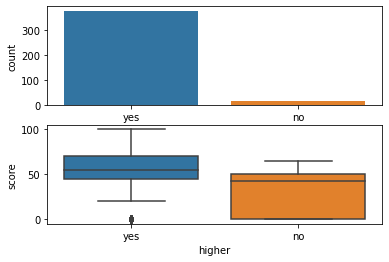

In [121]:
stud.higher = stud.higher.fillna('yes')
eda_nom('higher')

# studytime, granular

count    387.000000
mean      -6.124031
std        2.524515
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

-6.0     49.24
-3.0     25.89
-9.0     16.24
-12.0     6.85
 NaN      1.78
Name: studytime, granular, dtype: float64

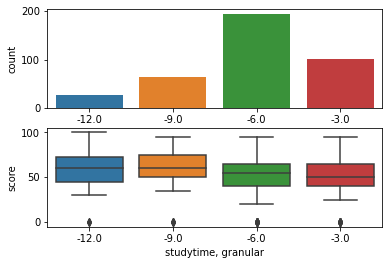

In [122]:
eda_nom('studytime, granular')

In [123]:
stud.corr()['studytime, granular']

age                    0.002354
Medu                  -0.078574
Fedu                   0.004989
traveltime             0.103420
studytime             -1.000000
failures               0.159365
studytime, granular    1.000000
famrel                -0.050025
freetime               0.119743
goout                  0.046045
health                 0.086577
absences               0.025392
score                 -0.114325
Name: studytime, granular, dtype: float64

In [125]:
del stud['studytime, granular']

# 22 internet — наличие интернета дома (yes или no)

count     360
unique      2
top       yes
freq      304
Name: internet, dtype: object

yes    77.16
no     14.21
NaN     8.63
Name: internet, dtype: float64

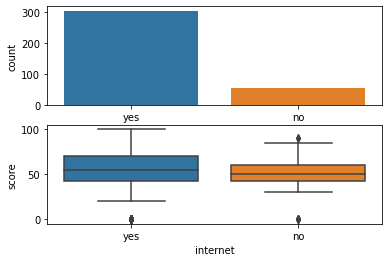

In [126]:
eda_nom('internet')

count     394
unique      2
top       yes
freq      338
Name: internet, dtype: object

yes    85.79
no     14.21
Name: internet, dtype: float64

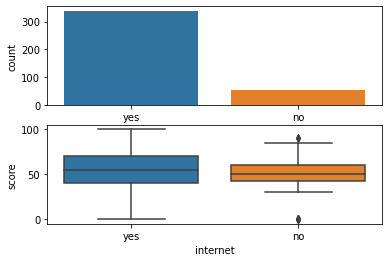

In [127]:
stud.internet = stud.internet.fillna('yes')
eda_nom('internet')

# 23 romantic — в романтических отношениях (yes или no)

count     363
unique      2
top        no
freq      240
Name: romantic, dtype: object

no     60.91
yes    31.22
NaN     7.87
Name: romantic, dtype: float64

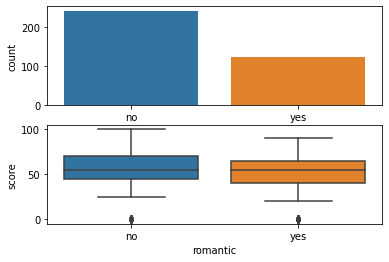

In [128]:
eda_nom('romantic')

count     394
unique      2
top        no
freq      271
Name: romantic, dtype: object

no     68.78
yes    31.22
Name: romantic, dtype: float64

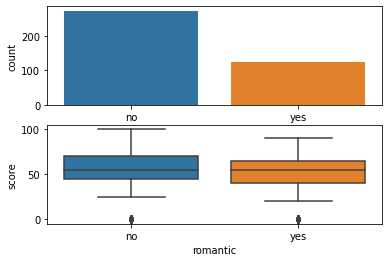

In [129]:
stud.romantic = stud.romantic.fillna('no')
eda_nom('romantic')

# 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

count    367.000000
mean       3.934605
std        0.926876
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

 4.0    46.19
 5.0    24.87
 3.0    15.74
 NaN     6.85
 2.0     4.31
 1.0     1.78
-1.0     0.25
Name: famrel, dtype: float64

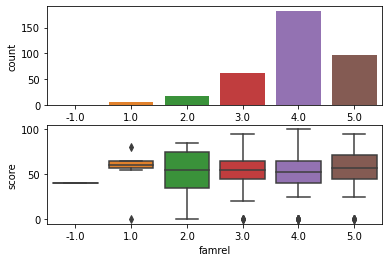

In [130]:
eda_nom('famrel')

count    394.000000
mean       3.939086
std        0.894624
min       -1.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: famrel, dtype: float64

 4.0    53.05
 5.0    24.87
 3.0    15.74
 2.0     4.31
 1.0     1.78
-1.0     0.25
Name: famrel, dtype: float64

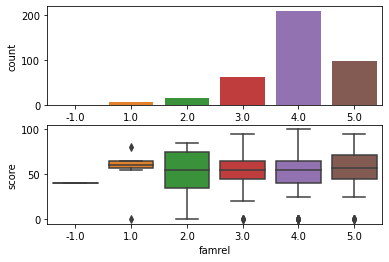

In [131]:
stud.famrel = stud.famrel.fillna(
    stud.describe().famrel['50%'])
eda_nom('famrel')

# 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого

count    383.000000
mean       3.229765
std        0.994462
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

3.0    38.83
4.0    28.17
2.0    15.99
5.0     9.64
1.0     4.57
NaN     2.79
Name: freetime, dtype: float64

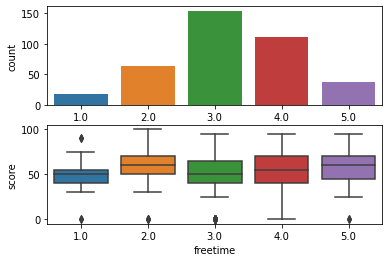

In [133]:
eda_nom('freetime')

count    394.000000
mean       3.223350
std        0.981178
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

3.0    41.62
4.0    28.17
2.0    15.99
5.0     9.64
1.0     4.57
Name: freetime, dtype: float64

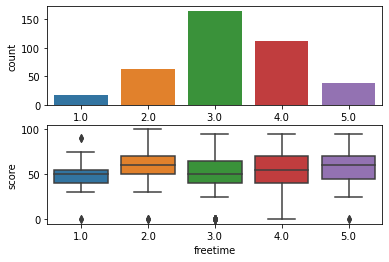

In [134]:
stud.freetime = stud.freetime.fillna(
    stud.describe().freetime['50%'])
eda_nom('freetime')

# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

count    386.000000
mean       3.101036
std        1.113156
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

3.0    32.23
2.0    25.63
4.0    21.32
5.0    12.94
1.0     5.84
NaN     2.03
Name: goout, dtype: float64

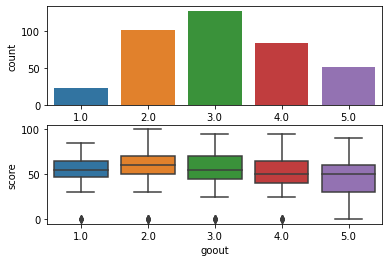

In [135]:
eda_nom('goout')

count    394.000000
mean       3.098985
std        1.101860
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

3.0    34.26
2.0    25.63
4.0    21.32
5.0    12.94
1.0     5.84
Name: goout, dtype: float64

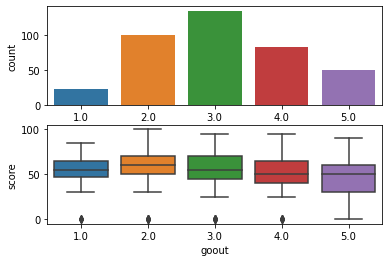

In [136]:
stud.goout = stud.goout.fillna(
    stud.describe().goout['50%'])
eda_nom('goout')

# 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

count    379.000000
mean       3.538259
std        1.391770
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

5.0    35.03
3.0    22.59
4.0    15.99
1.0    11.68
2.0    10.91
NaN     3.81
Name: health, dtype: float64

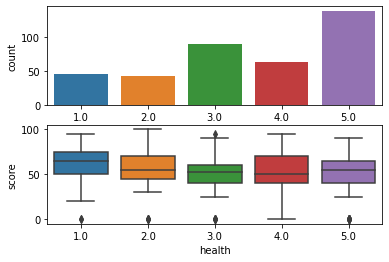

In [137]:
eda_nom('health')

count    394.000000
mean       3.555838
std        1.367816
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

5.0    35.03
3.0    22.59
4.0    19.80
1.0    11.68
2.0    10.91
Name: health, dtype: float64

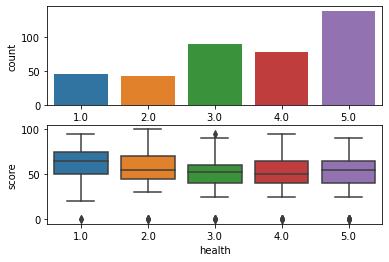

In [138]:
stud.health = stud.health.fillna(
    stud.describe().health['50%'])
eda_nom('health')

# 28 absences — количество пропущенных занятий

Количество уникальных значений: 36


count    382.000000
mean       7.256545
std       23.491712
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


0.0      28.17
2.0      15.23
4.0      13.45
6.0       7.87
8.0       5.33
10.0      4.31
12.0      3.05
NaN       3.05
14.0      3.05
3.0       2.03
16.0      1.52
7.0       1.52
5.0       1.27
18.0      1.27
20.0      1.02
1.0       0.76
22.0      0.76
9.0       0.76
13.0      0.51
15.0      0.51
11.0      0.51
25.0      0.25
54.0      0.25
385.0     0.25
26.0      0.25
56.0      0.25
24.0      0.25
212.0     0.25
21.0      0.25
75.0      0.25
30.0      0.25
19.0      0.25
38.0      0.25
40.0      0.25
23.0      0.25
17.0      0.25
28.0      0.25
Name: absences, dtype: float64

Выбросы:


C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Series([], Name: absences, dtype: float64)

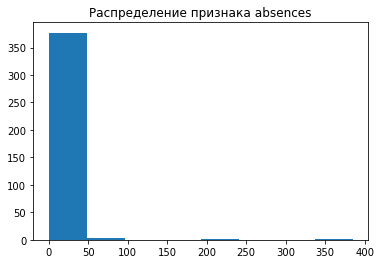

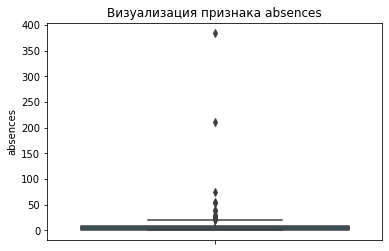

In [140]:
eda_num('absences')

In [158]:
outliers_iqr(stud.absences)[0]

-12.0

Оставим только строки, где значение не более 30.

In [160]:
stud = stud.loc[stud.absences.between(outliers_iqr(stud.absences)[0], 30)]

Количество уникальных значений: 29


count    375.000000
mean       5.098667
std        5.835387
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

0.0     29.60
2.0     16.00
4.0     14.13
6.0      8.27
8.0      5.60
10.0     4.53
12.0     3.20
14.0     3.20
3.0      2.13
16.0     1.60
7.0      1.60
5.0      1.33
18.0     1.33
20.0     1.07
22.0     0.80
1.0      0.80
9.0      0.80
13.0     0.53
11.0     0.53
15.0     0.53
17.0     0.27
25.0     0.27
26.0     0.27
23.0     0.27
28.0     0.27
21.0     0.27
30.0     0.27
19.0     0.27
24.0     0.27
Name: absences, dtype: float64

Выбросы:


[-12.0, 20.0]

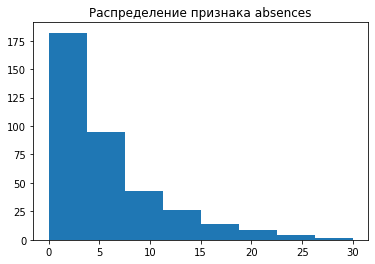

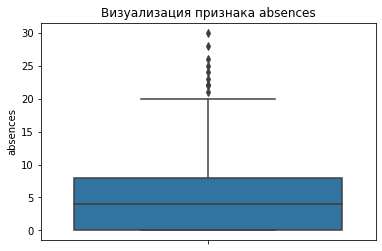

In [161]:
eda_num('absences')

# 29 score — баллы по госэкзамену по математике

Количество уникальных значений: 18


count    370.000000
mean      52.067568
std       22.952367
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


50.0     14.13
55.0     11.73
0.0       9.60
65.0      8.27
75.0      8.27
60.0      7.73
70.0      7.20
40.0      6.93
45.0      6.67
80.0      4.27
30.0      4.00
90.0      2.93
35.0      2.40
25.0      1.87
95.0      1.33
NaN       1.33
85.0      0.80
100.0     0.27
20.0      0.27
Name: score, dtype: float64

Выбросы:


[-5.0, 115.0]

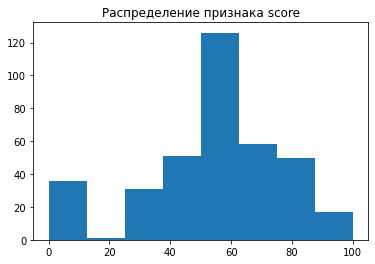

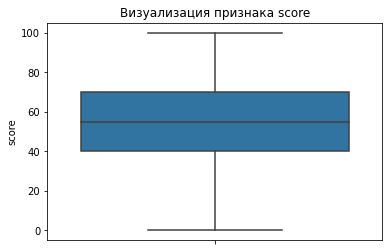

In [162]:
eda_num('score')

Удалим пропуски.

In [164]:
stud = stud.dropna(subset=['score'])

Количество уникальных значений: 18


count    370.000000
mean      52.067568
std       22.952367
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

50.0     14.32
55.0     11.89
0.0       9.73
75.0      8.38
65.0      8.38
60.0      7.84
70.0      7.30
40.0      7.03
45.0      6.76
80.0      4.32
30.0      4.05
90.0      2.97
35.0      2.43
25.0      1.89
95.0      1.35
85.0      0.81
100.0     0.27
20.0      0.27
Name: score, dtype: float64

Выбросы:


[-5.0, 115.0]

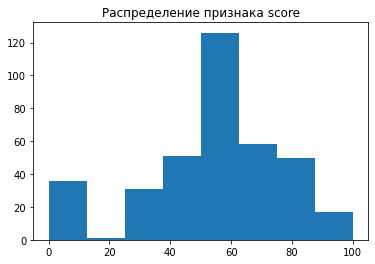

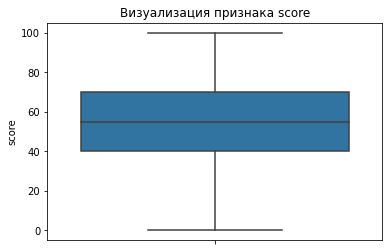

In [165]:
eda_num('score')

# Корреляционный анализ

In [166]:
num_col = ['age', 'absences', 'score']
bin_col = ['school', 'sex', 'address', 'famsize', 'Pstatus',
           'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime',
           'goout', 'health']
cat_col = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason',
           'guardian', 'traveltime', 'studytime', 'failures']

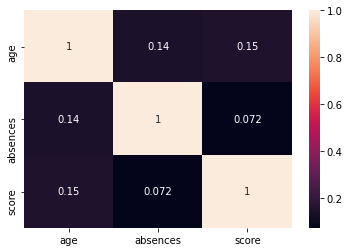

In [174]:
sns.heatmap(stud[num_col].corr().abs(), annot=True);

Корреляция слабая

In [179]:
for col in bin_col + cat_col:
    nominative_analisys(stud[stud.score>0], col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures


C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


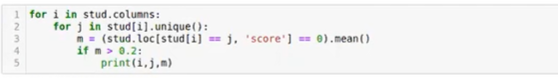

In [182]:
for column in stud.columns:
    for val in stud[column].unique():
        m = (stud.loc[stud[column] == val, 'score'] == 0).mean()
        if m > 0.2:
            print(column, val, m)

age 19 0.2631578947368421
failures 3.0 0.25
failures 2.0 0.2857142857142857
failures 1.0 0.2222222222222222
higher no 0.3333333333333333
absences 0.0 0.32727272727272727
score 0.0 1.0
